In [1]:
import graphlab

In [2]:
graphlab.canvas.set_target('ipynb')

In [66]:
taps = graphlab.SFrame.read_csv("taps.csv", verbose=False)
taps[taps['type'] == "TOUCH"]['action'].show()
taps[taps['type'] == "SWIPE"]['action'].show()

In [67]:
features = [
    "n_accel",
    
    "accel_x_mean",
    "accel_x_median",
    "accel_x_var",
    "accel_x_skewness",
    "accel_x_kurtosis",
    "accel_x_diff",
    
    "accel_y_mean",
    "accel_y_median",
    "accel_y_skewness",
    "accel_y_kurtosis",
    "accel_y_var",
    "accel_y_diff",
    
    "accel_z_mean",
    "accel_z_var",   
    "accel_z_median",
    "accel_z_skewness",
    "accel_z_kurtosis",
    "accel_z_diff",
    
    "n_gyro",
    
    "gyro_x_mean",
    "gyro_x_median",
    "gyro_x_var",
    "gyro_x_skewness",
    "gyro_x_kurtosis",
    "gyro_x_diff",
    
    "gyro_y_mean",
    "gyro_y_median",
    "gyro_y_var",
    "gyro_y_skewness",
    "gyro_y_kurtosis",
    "gyro_y_diff",
    
    "gyro_z_mean",
    "gyro_z_median",
    "gyro_z_var",
    "gyro_z_skewness",
    "gyro_z_kurtosis",
    "gyro_z_diff",
    
] 



In [68]:
train, test = taps.random_split(0.8, seed=1)


In [69]:
not_noise_train = train[train['noise'] == 0]
not_noise_test = test[test['noise'] == 0]

noise_train = train[train['noise'] == 1]
noise_test = test[test['noise'] == 1]

In [70]:
train_touchs = not_noise_train[not_noise_train['type'] == "TOUCH"]
train_swipes = not_noise_train[not_noise_train['type'] == "SWIPE"]
test_touchs = not_noise_test[not_noise_test['type'] == "TOUCH"]
test_swipes = not_noise_test[not_noise_test['type'] == "SWIPE"]

# Let's focus on boosted trees.

In [71]:
k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train), 5)

In [77]:
def f1_score(model, data):
    return model.evaluate(data, metric='f1_score')['f1_score']

def accuracy(model, data):
    return model.evaluate(data, metric='accuracy')['accuracy']

def get_cross_val_score(k_fold, model_factory, model_params, metric_f):
    val_errors = []
    train_errors = []
    for train, valid in k_fold:
        m = model_factory(train, **model_params)
        val_errors.append(metric_f(m, valid))
        train_errors.append(metric_f(m, train))
    return sum(train_errors)/float(len(train_errors)), sum(val_errors)/float(len(val_errors))


def get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for max_iterations in max_iterations_a:
        model_params['max_iterations'] = max_iterations
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At iterations:", max_iterations, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(max_iterations_a, val_a)
        plt.plot(max_iterations_a, train_a)
    if metric_f == f1_score or metric_f == accuracy:
        return max_iterations_a[val_a.index(max(val_a))], max(val_a)
    return max_iterations_a[val_a.index(min(val_a))], min(val_a)

def get_best_depth(k_fold, depths, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for depth in depths:
        model_params['max_depth'] = depth
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At depth:", depth, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(depths, val_a)
        plt.plot(depths, train_a)
    if metric_f == f1_score or metric_f == accuracy:
        return depths[val_a.index(max(val_a))], max(val_a)
    return depths[val_a.index(min(val_a))], min(val_a)

At iterations: 5 0.668194260236 0.668597793267
At iterations: 10 0.705347518131 0.70654541863
At iterations: 20 0.72586279877 0.726731946835
At iterations: 40 0.737590653836 0.738962101758
At iterations: 80 0.748900866326 0.749788356802
At iterations: 160 0.756570815814 0.757599401755
At iterations: 320 0.763337754325 0.764841831984
At iterations: 640 0.768710669639 0.770949854672


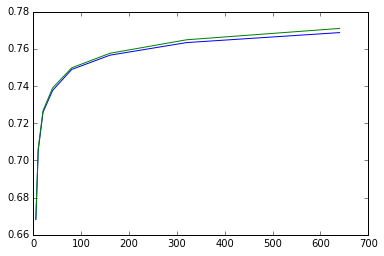

In [78]:
max_iterations_a = [5, 10, 20, 40, 80, 160, 320, 640]
model_params = dict([('target', 'noise'), ('features', features), ('verbose', False), ('validation_set', None),
                    ('max_depth', 1)])
model_factory = graphlab.boosted_trees_classifier.create
noise_max_iterations = get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.768710669639 0.770949854672
At depth: 2 0.831622315659 0.840073934024
At depth: 3 0.870762197703 0.890265823856
At depth: 4 0.909783559556 0.940058413523
At depth: 5 0.939458757796 0.976218359342
At depth: 6 0.957874537912 0.994686344781
At depth: 7 0.967350509355 0.999602110788
At depth: 8 0.97089482744 0.999994356181
At depth: 9 0.97239608319 1.0


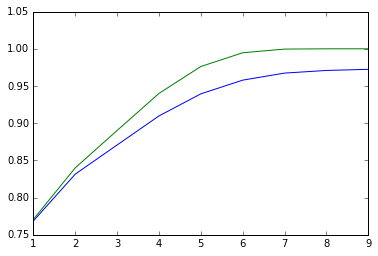

In [79]:
depths = range(1,10)
model_params['max_iterations'] = noise_max_iterations[0]
noise_max_depth = get_best_depth(k_fold, depths, model_factory, model_params, accuracy)

In [80]:
train_set_to_use = train
max_depth_to_use = noise_max_depth[0]
max_iterations_to_use = noise_max_iterations[0]

optimized_noise_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='noise', 
                                                                      features=features,
                                                                      max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      validation_set=None,
                                                                      verbose=False)

In [81]:
print optimized_noise_classifier.evaluate(test)

{'f1_score': 0.9796506087877184, 'auc': 0.9971727947031478, 'recall': 0.979463945463014, 'precision': 0.9798373432734666, 'log_loss': 0.06388816759374655, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+-------+-------+
| threshold |      fpr       |      tpr       |   p   |   n   |
+-----------+----------------+----------------+-------+-------+
|    0.0    |      1.0       |      1.0       | 23617 | 20838 |
|   1e-05   | 0.912467607256 |      1.0       | 23617 | 20838 |
|   2e-05   | 0.87997888473  | 0.99995765762  | 23617 | 20838 |
|   3e-05   | 0.857855840292 | 0.99995765762  | 23617 | 20838 |
|   4e-05   | 0.839811882138 | 0.99995765762  | 23617 | 20838 |
|   5e-05   | 0.822727708993 | 0.99995765762  | 23617 | 20838 |
|   6e-05   | 0.808810826375 | 0.99995765762  | 23617 | 20838 |
|   7e-05   | 0.798493137537 | 0.99995765762  | 23617 | 20838 |
|   8e-05   | 0.787839523947 | 0.99995765762 

In [82]:
predicted_not_noise = test[optimized_noise_classifier.predict(test) == 0]

# Type classifier now

In [83]:
not_noise_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(not_noise_train), 5)

At iterations: 5 0.753870673797 0.7538978314
At iterations: 10 0.787531632498 0.788229491505
At iterations: 20 0.807766722629 0.807989361764
At iterations: 40 0.820109911931 0.821276897846
At iterations: 80 0.832886157164 0.833692240406
At iterations: 160 0.843737570104 0.84538274493
At iterations: 320 0.852363376439 0.854775454077
At iterations: 640 0.858366535926 0.861774119829


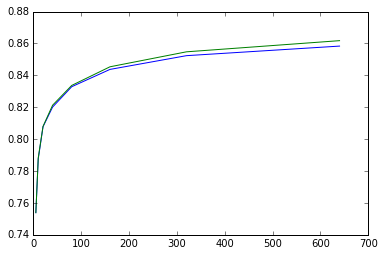

In [85]:
model_params = {'target': 'type', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
type_max_iterations = get_best_max_iterations(not_noise_k_fold, max_iterations_a, model_factory, 
                                              model_params, accuracy)

At depth: 1 0.858366535926 0.861774119829
At depth: 2 0.924365090059 0.934852565146
At depth: 3 0.962008110748 0.977403967423
At depth: 4 0.983073273897 0.996354799523
At depth: 5 0.991157674021 0.999882704008
At depth: 6 0.99339532807 1.0
At depth: 7 0.993864503173 1.0
At depth: 8 0.994165265908 1.0
At depth: 9 0.994008869865 1.0


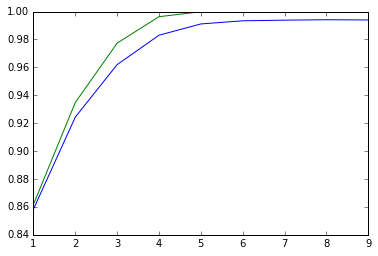

In [86]:
depths = range(1,10)

model_params['max_iterations'] = type_max_iterations[0]
type_max_depth = get_best_depth(not_noise_k_fold, depths, model_factory, model_params, accuracy)

In [87]:
train_set_to_use = not_noise_train
max_depth_to_use = type_max_depth[0]
max_iterations_to_use = type_max_iterations[0]

optimized_type_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='type', 
                                                                     features=features, max_depth=max_depth_to_use, 
                                                                     max_iterations=max_iterations_to_use,
                                                                     verbose=False, validation_set=None)

In [88]:
print optimized_type_classifier.evaluate(predicted_not_noise)

predicted_touches = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "TOUCH"]
predicted_swipes = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "SWIPE"]

{'f1_score': 0.6573326278131989, 'auc': 0.9998207155186319, 'recall': 0.665160566395531, 'precision': 0.9745665074264691, 'log_loss': 0.8126082711684043, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+-----+-------+-------+
| threshold |      fpr       | tpr |   p   |   n   |
+-----------+----------------+-----+-------+-------+
|    0.0    |      1.0       | 1.0 | 10138 | 10224 |
|   1e-05   | 0.658548513302 | 1.0 | 10138 | 10224 |
|   2e-05   | 0.590375586854 | 1.0 | 10138 | 10224 |
|   3e-05   | 0.546068075117 | 1.0 | 10138 | 10224 |
|   4e-05   | 0.516431924883 | 1.0 | 10138 | 10224 |
|   5e-05   | 0.486991392801 | 1.0 | 10138 | 10224 |
|   6e-05   | 0.465179968701 | 1.0 | 10138 | 10224 |
|   7e-05   | 0.447183098592 | 1.0 | 10138 | 10224 |
|   8e-05   | 0.433881064163 | 1.0 | 10138 | 10224 |
|   9e-05   | 0.419307511737 | 1.0 | 10138 | 10224 |
+-----------+----------------+-----+-------+-------+
[100001 

# Let's classify swipes

In [89]:
swipes_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_swipes), 5)

At iterations: 5 0.476700450514 0.479318116527
At iterations: 10 0.513117989729 0.516523833672
At iterations: 20 0.542747621611 0.547621912922
At iterations: 40 0.594569804479 0.598956576998
At iterations: 80 0.631564914677 0.638184186696
At iterations: 160 0.658306320883 0.666652623675
At iterations: 320 0.678934051329 0.689542921781
At iterations: 640 0.697058524248 0.709990130111


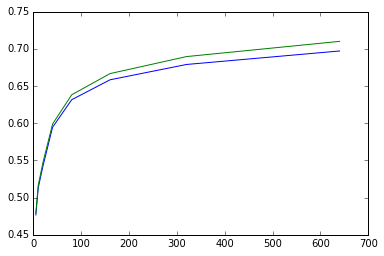

In [90]:
model_params = {'target': 'action', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
swipe_max_iterations = get_best_max_iterations(swipes_k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.697058524248 0.709990130111
At depth: 2 0.881721378773 0.911724357156
At depth: 3 0.968829806139 0.991232605907
At depth: 4 0.98904830408 1.0
At depth: 5 0.992081078917 1.0
At depth: 6 0.992851328044 1.0
At depth: 7 0.99309201931 1.0
At depth: 8 0.993140148294 1.0
At depth: 9 0.993092013517 1.0


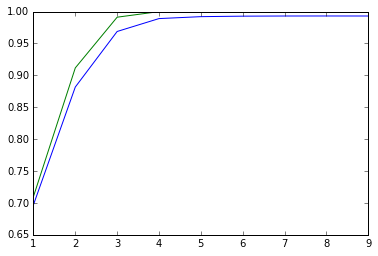

In [91]:
depths = range(1,10)

model_params['max_iterations'] = swipe_max_iterations[0]
swipe_max_depth = get_best_depth(swipes_k_fold, depths, model_factory, model_params, accuracy)

In [92]:
train_set_to_use = train_swipes
max_depth_to_use = swipe_max_depth[0]
max_iterations_to_use = swipe_max_iterations[0]

optimized_swipe_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', 
                                                                      features=features, max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      verbose=False, validation_set=None)

In [93]:
print optimized_swipe_classifier.evaluate(predicted_swipes)

{'f1_score': 0.3596427784362366, 'auc': 0.9999706885499008, 'recall': 0.36274571305150904, 'precision': 0.980640195621881, 'log_loss': 0.5940071362241232, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 400004

Data:
+-----------+----------------+-----+------+------+-------+
| threshold |      fpr       | tpr |  p   |  n   | class |
+-----------+----------------+-----+------+------+-------+
|    0.0    |      1.0       | 1.0 | 2531 | 7670 |   0   |
|   1e-05   | 0.401694915254 | 1.0 | 2531 | 7670 |   0   |
|   2e-05   | 0.314211212516 | 1.0 | 2531 | 7670 |   0   |
|   3e-05   | 0.267275097784 | 1.0 | 2531 | 7670 |   0   |
|   4e-05   | 0.233116036506 | 1.0 | 2531 | 7670 |   0   |
|   5e-05   | 0.209517601043 | 1.0 | 2531 | 7670 |   0   |
|   6e-05   | 0.191134289439 | 1.0 | 2531 | 7670 |   0   |
|   7e-05   | 0.177183833116 | 1.0 | 2531 | 7670 |   0   |
|   8e-05   | 0.165319426336 | 1.0 | 2531 | 7670 |   0   |
|   9e-05   | 0.153063885267 |

# Let's go with touch classifier

In [95]:
touches_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_touchs), 5)

At iterations: 5 0.319239458121 0.325089571362
At iterations: 10 0.365899547547 0.370842048995
At iterations: 20 0.411742199361 0.419246181868
At iterations: 40 0.467085163116 0.477631851473
At iterations: 80 0.51477976223 0.527094298566
At iterations: 160 0.549775011519 0.565156203465
At iterations: 320 0.581619456021 0.602388329931
At iterations: 640 0.612020907758 0.640191685141


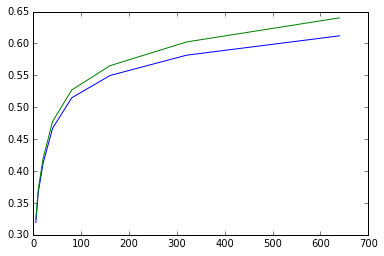

In [97]:
model_params = {'target': 'action', 'features': features, 'verbose': False, 'validation_set': None, 'max_depth': 1}
model_factory = graphlab.boosted_trees_classifier.create
touch_max_iterations = get_best_max_iterations(touches_k_fold, max_iterations_a, model_factory, model_params, accuracy)

At depth: 1 0.697058524248 0.709990130111
At depth: 2 0.881721378773 0.911724357156
At depth: 3 0.968829806139 0.991232605907
At depth: 4 0.98904830408 1.0
At depth: 5 0.992081078917 1.0
At depth: 6 0.992851328044 1.0
At depth: 7 0.99309201931 1.0
At depth: 8 0.993140148294 1.0
At depth: 9 0.993092013517 1.0


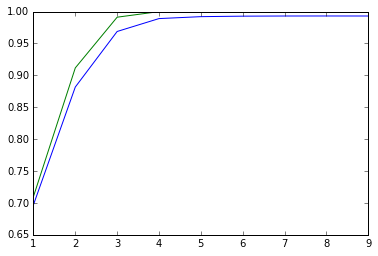

In [98]:
depths = range(1,10)

model_params['max_iterations'] = touch_max_iterations[0]
touch_max_depth = get_best_depth(swipes_k_fold, depths, model_factory, model_params, accuracy)

In [103]:
train_set_to_use = train_touchs
max_depth_to_use = touch_max_depth[0]
max_iterations_to_use = touch_max_iterations[0]

optimized_touch_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', 
                                                                      features=features, max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use,
                                                                      verbose=False, validation_set=None)

In [104]:
print optimized_touch_classifier.evaluate(predicted_touches)

{'f1_score': 0.6272983118257554, 'auc': 0.9999458998401484, 'recall': 0.638293037379739, 'precision': 0.9593094920674547, 'log_loss': 1.1961397119741706, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 900009

Data:
+-----------+----------------+-----+------+------+-------+
| threshold |      fpr       | tpr |  p   |  n   | class |
+-----------+----------------+-----+------+------+-------+
|    0.0    |      1.0       | 1.0 | 1131 | 8984 |   0   |
|   1e-05   | 0.416295636687 | 1.0 | 1131 | 8984 |   0   |
|   2e-05   | 0.347284060552 | 1.0 | 1131 | 8984 |   0   |
|   3e-05   | 0.307546749777 | 1.0 | 1131 | 8984 |   0   |
|   4e-05   | 0.279051647373 | 1.0 | 1131 | 8984 |   0   |
|   5e-05   | 0.255231522707 | 1.0 | 1131 | 8984 |   0   |
|   6e-05   | 0.23552983081  | 1.0 | 1131 | 8984 |   0   |
|   7e-05   | 0.220837043633 | 1.0 | 1131 | 8984 |   0   |
|   8e-05   | 0.208593054319 | 1.0 | 1131 | 8984 |   0   |
|   9e-05   | 0.198130008905 | 

In [105]:
optimized_noise_classifier.save("noise_model")
optimized_type_classifier.save("type_model")
optimized_swipe_classifier.save("swipe_model")
optimized_touch_classifier.save("touch_model")